In [1]:
import geopandas as gpd
from tqdm import tqdm
from shapely.validation import explain_validity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import calendar
from itertools import cycle

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
os.chdir("../scripts")
from clustering_operations import *
from HierarchicalClusteringOptimized import HierarchicalClustering

%load_ext autoreload
%autoreload 2

In [3]:
level = 7
shapefile_coarser = gpd.read_file(f'../data/shapefiles/FAPAN_level_0{level}/comparison_4na.shp')

In [4]:
shp = gpd.read_file('../data/shapefiles/FAPAN_domain_fixed_geometry/FAPAN_domain_fixed_geometry_availability05_final.shp')

#### Consider only the original sub-basins which fully compose a sub-basin in level X

In [5]:
df_coarser = pd.read_csv(f'../data/FAPAN_level_0{level}_corrected.csv', sep=',')
df = pd.read_csv("../data/FAPAN204_05.csv", sep=',')

In [6]:
subid_coarser = list(shapefile_coarser["SUBID"])

In [7]:
df_coarser_4na = df_coarser[df_coarser["HYBAS_ID"].isin(subid_coarser)]

In [8]:
valid_subids = set()
for index, row in df_coarser_4na.iterrows():
    subids = row["SUBIDs"].split("_")
    for subid in subids:
        valid_subids.add(subid)
        
print(len(valid_subids))
valid_subids = list(map(str, valid_subids))

26598


In [9]:
df['SUBID'] = df['SUBID'].astype(int).astype(str)
shp['SUBID'] = shp['SUBID'].astype(int).astype(str)
df = df[df["SUBID"].isin(valid_subids)].reset_index(drop=True)
shp = shp[shp["SUBID"].isin(valid_subids)].reset_index(drop=True)
print(df.shape)
print(shp.shape)

(26598, 207)
(26598, 22)


<AxesSubplot:>

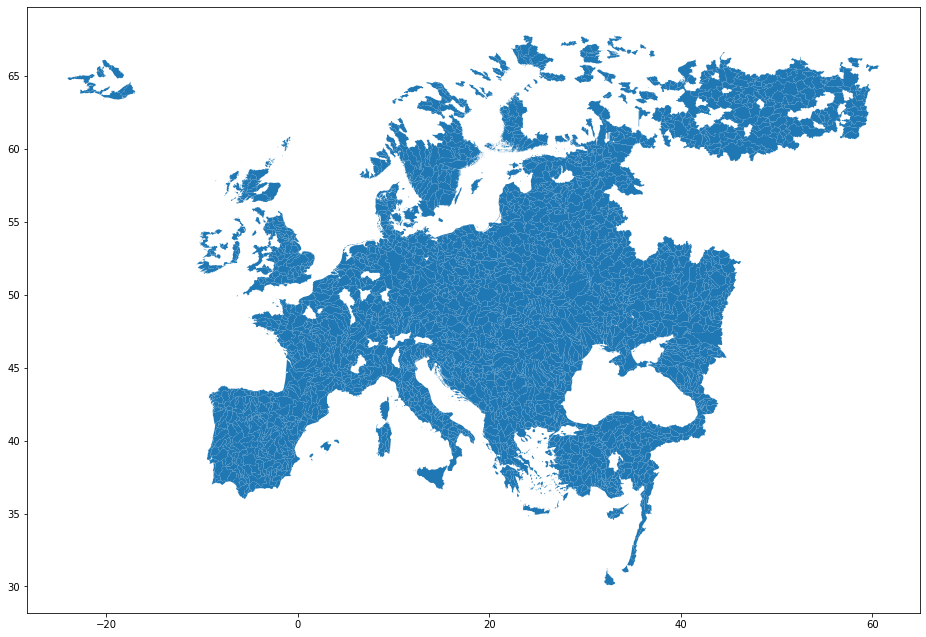

In [10]:
shapefile_coarser.plot(figsize=(16,16))

<AxesSubplot:>

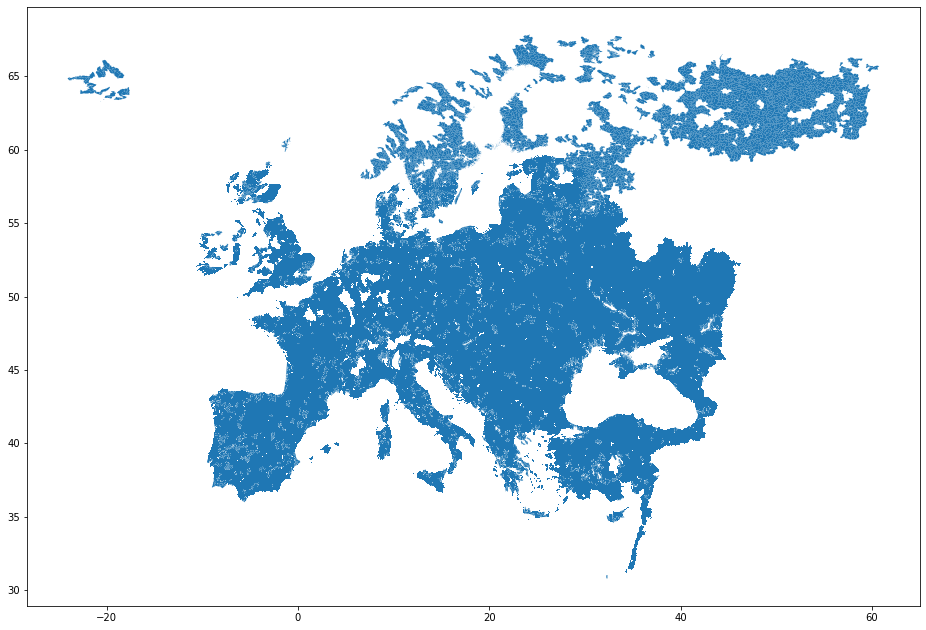

In [11]:
shp.plot(figsize=(16,16))

In [12]:
def select_columns_by_months(dataframe, selected_months):
    selected_columns = []

    for i in range((dataframe.shape[1] - 3) // 12):
        selected_columns.extend([month + i * 12 for month in selected_months])

    all_columns = np.arange(1, dataframe.shape[1]-2)
    columns_to_drop = np.setdiff1d(all_columns, np.array(selected_columns))
    columns_to_drop = [str(i) for i in columns_to_drop]

    filtered_dataframe = dataframe.drop(columns=columns_to_drop, axis=1)

    return filtered_dataframe

In [13]:
df = select_columns_by_months(df, [4,5,6,7,8,9])
df.shape

(26598, 105)

In [14]:
df.head()

,SUBID,x,y,4,5,6,7,8,9,16,...,186,187,188,189,196,197,198,199,200,201
0,8000005,9.3096,59.1909,0.187556,0.371778,-0.197000,-0.361333,1.086444,0.963111,-0.534333,...,0.341667,0.502111,0.461333,-1.894111,-0.461184,1.374222,0.705667,0.906444,0.006111,0.671000
1,8115258,8.7466,59.1359,-0.245083,0.815444,-0.115556,-0.607519,1.011852,0.708333,-0.594933,...,0.314370,0.490519,-0.576593,-2.895556,-1.772971,1.125889,0.715222,1.261407,-0.258074,-0.028667
2,8115717,9.2398,58.9271,0.242000,-0.082444,-1.187556,-0.751778,0.860667,1.069778,-0.592444,...,0.406667,0.541444,0.268444,-1.212222,-0.675084,1.587889,1.250889,1.530667,-0.349889,0.421222
3,8102609,9.1371,58.9647,0.371667,0.523533,-0.586733,-0.437733,0.851200,1.108467,-1.133250,...,0.870133,0.855667,0.562333,-2.557400,NaN,1.233200,1.278556,1.541600,-0.056200,-0.116467
4,8103951,9.0461,59.1257,0.090185,0.343000,-0.465481,-0.418556,0.877259,1.107815,-0.699926,...,0.779556,0.867926,0.726259,-2.251519,NaN,1.317556,0.857733,1.314333,0.112074,-0.040444


## Compute neighbours

In [ ]:
# add neighbours column
shp["NEIGHBOURS"] = None  
    
progress_bar = tqdm(total=shp.shape[0], position=0, leave=True, smoothing=0)

for index, country in shp.iterrows():   
    #print(index)
    # get 'not disjoint' countries
    neighbours = shp[~shp.geometry.disjoint(country.geometry)]['SUBID'].tolist()

    # remove own name of the country from the list
    neighbours = [ name for name in neighbours if country['SUBID'] != name ]

    # add names of neighbours as neighbours value
    shp.at[index, "NEIGHBOURS"] = neighbours
                   
    progress_bar.update(1)  

In [ ]:
# Create a set to store unique pairs
neighbours_pairs = set()

# Iterate over each row and generate pairs
for index, row in shp.iterrows():
    subid = row['SUBID']
    neighbors = row['NEIGHBOURS']
    
    # Generate pairs and add to the set
    for neighbor in neighbors:
        pair = tuple(sorted([subid, neighbor]))
        neighbours_pairs.add(pair)

df_without_neighbours = shp[shp["NEIGHBOURS"].apply(len)==0][["SUBID"]]
without_neighbours = df_without_neighbours["SUBID"].to_list()      

## Compute and visualize clusterings

In [ ]:
# Transpose the DataFrame and set the "SUBID" column as the column names
df = df.set_index('SUBID').T
df = df.reset_index(drop=True)
df = df.rename_axis(None, axis=1)
df = df.astype(float)
df.head()

# Clustering

In [ ]:
clustering = HierarchicalClustering(df, neighbours_pairs, without_neighbours, method='complete_correlation', threshold=0.5, missing_values=True)
clustering.compute_clusters()

In [ ]:
clustering.get_clustering_count_analysis()

In [ ]:
clusters = clustering.get_clusters_from_last_fathers(0.8)
plot_clusters_shp(shp, clusters, figsize=(16,16))

In [ ]:
clusters = clustering.get_clusters_from_last_fathers(0.8)

clusters_size = []
for cluster in clusters:
    clusters_size.append(len(cluster))

plt.hist(clusters_size, bins=np.array(range(clusters_size[0]+2)))
plt.show()

In [ ]:
clusters_weighted_mean = compute_clusters_mean(df, shp, clusters, weighted=True)

In [ ]:
avg_corr_with_mean = correlations_sub_cluster(df_finer, clusters, clusters_weighted_mean)
no_singletons = remove_singletons(clusters)
print(f'No. clusters (w/o singletons): {len(no_singletons)}')
print(f'No. singletons): {len(avg_corr_with_mean) - len(no_singletons)}')
plot_hist_with_mean(avg_corr_with_mean, title="Clusters With Singletons")
plot_hist_with_mean(avg_corr_with_mean[:len(no_singletons)], title="Clusters Without Singletons")